In [2]:
import pandas as pd
import numpy as np
import scanpy as sc

In [9]:
parc_id_table_path = 'gene/parcellation_to_parcellation_term_membership_acronym.csv'
parc_id_table = pd.read_csv(parc_id_table_path)

In [10]:
parc_id_match = {}
id_parc_match = {}
for i in range(len(parc_id_table)):
    parc_id_match[parc_id_table['parcellation_index'].iloc[i]] = parc_id_table['substructure'].iloc[i]
    id_parc_match[parc_id_table['substructure'].iloc[i]] = parc_id_table['parcellation_index'].iloc[i]

In [4]:
T1 = pd.read_csv('gene/screened1_matrix.csv')

In [11]:
c1_table_path = 'gene/cell_metadata_with_cluster_annotation_1.csv'
c1_table = pd.read_csv(c1_table_path)

In [6]:
annotation_table_path = 'gene/41586_2023_6812_MOESM8_ESM.xlsx'
annotation_table = pd.read_excel(annotation_table_path)

In [7]:
subclass_to_neighborhood = {}
for i in np.unique(annotation_table['subclass_id']):
     neigh_rowid = annotation_table[annotation_table['subclass_id'] == i].index[0]
     neigh = annotation_table['neighborhood'].iloc[neigh_rowid]
     subclass_to_neighborhood[i] = neigh

In [4]:
import glob
import os
import sys
sys.path.append("../pylib-main")
from file_io import load_image
from anatomy.anatomy_config import REGION671
import json

In [9]:
parc_id_match_reverse = {}
for k,v in parc_id_match.items():
    parc_id_match_reverse[v] = k

In [5]:
tree_json_path = 'tree_yzx.json'
with open(tree_json_path, 'r') as file:
    tree_json = json.load(file) 

In [6]:
brain_to_id = {}
id_to_brain = {}
brain_id_path = {}
for i in range(len(tree_json)):
    bid = tree_json[i]['id']
    acronym = tree_json[i]['acronym']
    p = tree_json[i]['structure_id_path']
    if bid not in brain_to_id:
        brain_to_id[bid] = acronym
        id_to_brain[acronym] = bid
    if bid not in brain_id_path:
        brain_id_path[bid] = p 

In [8]:
major_BS = [688,549,623,313,1065,512,1097]
major_BS_name = ['CTX','TH','CNU','MB','HB','CB','HY','others']
region_Rough = {}
for i in REGION671:
    tmp_p = brain_id_path[i]
    flag = False
    for j in range(len(major_BS)):
        if major_BS[j] in tmp_p:
            region_Rough[brain_to_id[i]] = major_BS_name[j]
            flag = True
    if flag == False:
        region_Rough[brain_to_id[i]] = major_BS_name[len(major_BS_name)-1]

In [13]:
col_s = T1.columns[1:1123]

In [14]:
from scipy.spatial.distance import cdist
from sklearn import preprocessing

In [18]:
R_name_list = []
final_parc_folder = 'lyf/output_full_r671'
for f in glob.glob(final_parc_folder+"/*"):
    f_name = os.path.basename(f)
    region_id = int(f_name.split(".")[0].split("parc_region")[1])
    R_name = brain_to_id[region_id]
    R_name_list.append(R_name)

In [19]:
expression_df = []
selected_R = []
exp_regions = []
exp_parc_ids = []
Gclass_label = []
Gsubclass_label = []
Gcluster_label = []
for n in R_name_list:
    if n not in parc_id_match_reverse:
        acronym_name = n+"-unassigned"
    else:
        acronym_name = n
    if acronym_name in parc_id_match_reverse:
        nid = parc_id_match_reverse[acronym_name]
        rows1 = T1[T1['parcellation_index']==nid]
        s_names = np.array(rows1['cell_label'])
        c_df = c1_table[c1_table['cell_label'].isin(s_names)]
        R_df_tmp = pd.merge(c_df,rows1,on='cell_label')
        
        if len(rows1) > 0:
            region_id = id_to_brain[n]
            mask_path = 'lyf/output_full_r671/parc_region'+str(region_id)+'.nrrd'
            if not os.path.exists(mask_path):
                continue
            parc_mask_tmp = load_image(mask_path)

            tmp_df = R_df_tmp.copy()
            tmp_df['x_y'] = round(tmp_df['x_y']*40).astype(int)
            tmp_df['y_y'] = round(tmp_df['y_y']*40).astype(int)
            tmp_df['z_y'] = round(tmp_df['z_y']*40)
            tmp_df['z_y'] = tmp_df['z_y'].apply(lambda x: 456-x if x<228 else x)
            tmp_df['z_y'] = tmp_df['z_y'].astype(int)
            label_tmp = parc_mask_tmp[tmp_df['z_y'],tmp_df['y_y'],tmp_df['x_y']]
            # print(np.unique(label_tmp))
            gclass = tmp_df['class'].apply(lambda x:x.split(' ')[0])
            gsubclass = tmp_df['subclass'].apply(lambda x:x.split(' ')[0])
            gcluster = tmp_df['cluster_alias']
            
            for j in range(1,np.max(label_tmp)+1):
                rows_parc = tmp_df[label_tmp == j]
                if len(rows_parc) > 0:
                    exp_regions.append(n)
                    exp_parc_ids.append(j)
                    expression_df.append(np.array(rows_parc[col_s].mean()))
                    Gclass_label.append(gclass[label_tmp == j])
                    Gsubclass_label.append(gsubclass[label_tmp == j]) 
                    Gcluster_label.append(gcluster[label_tmp == j])   
            selected_R.append(n) 

In [20]:
expression_df = np.array(expression_df)
S_exp1 = (expression_df-np.mean(expression_df,axis=0))/np.std(expression_df,axis=0)
scaler = preprocessing.Normalizer(norm='l2')
S_exp2 = scaler.fit_transform(S_exp1)

D_exp = cdist(S_exp2,S_exp2,metric = 'cosine')
D_exp2 = (D_exp.max()-D_exp)/D_exp.max()

In [21]:
R_gene_parc = [region_Rough[x] for x in exp_regions]

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

/home/penglab/anaconda3/envs/python310/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/penglab/anaconda3/envs/python310/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


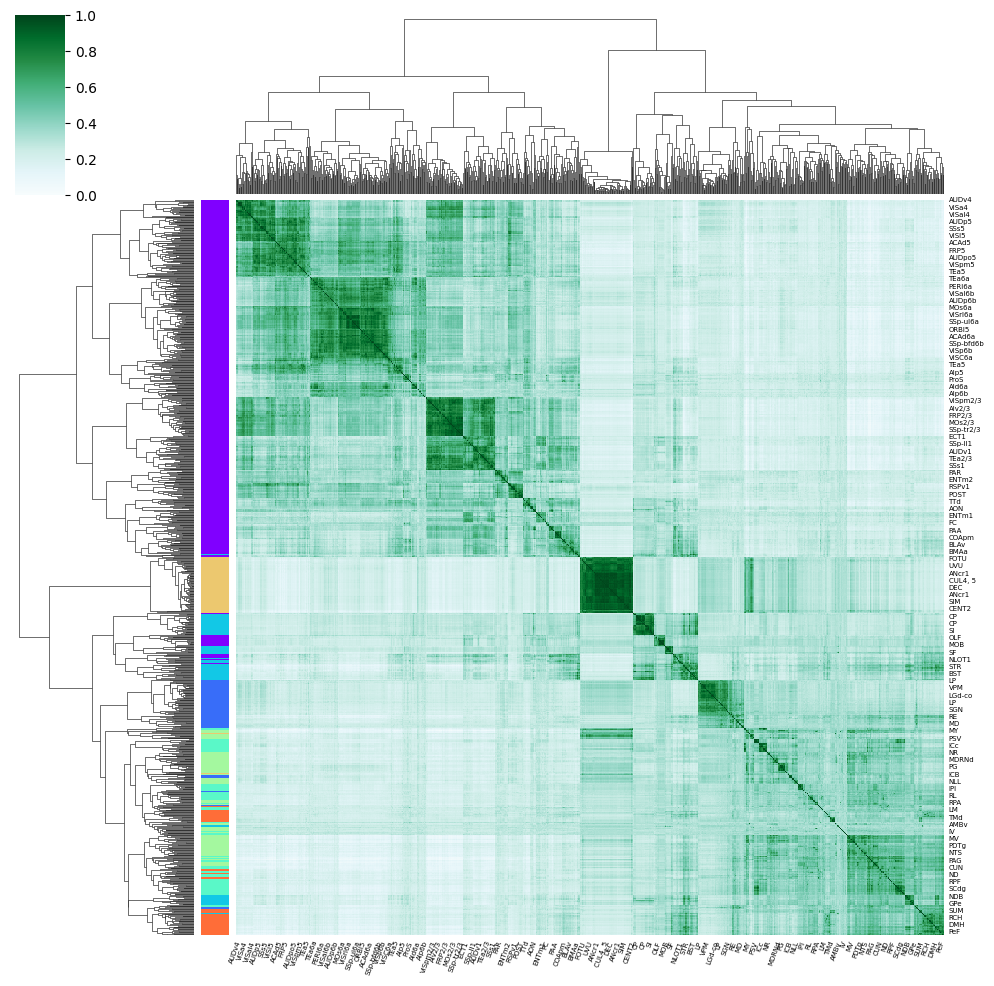

In [23]:
cmap = mpl.cm.rainbow
color_hm = cmap(np.linspace(0,1,len(major_BS_name)))
color_hm2 = [mpl.colors.rgb2hex(i,keep_alpha=False) for i in color_hm]
c = dict(zip(major_BS_name,color_hm2))
row_c = list(map(lambda x:c[x], R_gene_parc))
# sns.set(style="ticks", rc={'ytick.right':False,'ytick.left':False,'xtick.bottom':False,'xtick.top':False})
g_exp = sns.clustermap(data = D_exp2,
                       row_colors = row_c,
                       cmap='BuGn'
                       )
g_exp.ax_heatmap.set_xticks(np.arange(len(exp_regions)))
g_exp.ax_heatmap.set_yticks(np.arange(len(exp_regions)))

xticklabels = g_exp.data2d.columns
yticklabels = g_exp.data2d.columns

interval = 10
g_exp.ax_heatmap.set_xticklabels(
     [exp_regions[int(label)] if i % interval == 0 else '' for i,label in enumerate(xticklabels)],
     rotation=70,fontsize=5
)
g_exp.ax_heatmap.set_yticklabels(
     [exp_regions[int(label)] if i % interval == 0 else '' for i,label in enumerate(yticklabels)],
     rotation=0,fontsize=5
)

g_exp.ax_heatmap.tick_params(length=0)
# plt.savefig('all_figs/Fig5/gene_matrix_full2_avgLog.png',dpi=500)

In [43]:
class_stats = np.zeros((len(D_exp2),29))
reordered_index = g_exp.dendrogram_col.reordered_ind
for i in range(len(reordered_index)):
     class_rows = np.array(Gclass_label[reordered_index[i]])
     tmp_classes = np.unique(class_rows)
     total_N = len(class_rows)
     for j in tmp_classes:
          n = len(class_rows[class_rows == j])
          class_stats[i,int(j)-1] = n/total_N*100

In [26]:
class_stats = np.array(class_stats)

/home/penglab/anaconda3/envs/python310/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


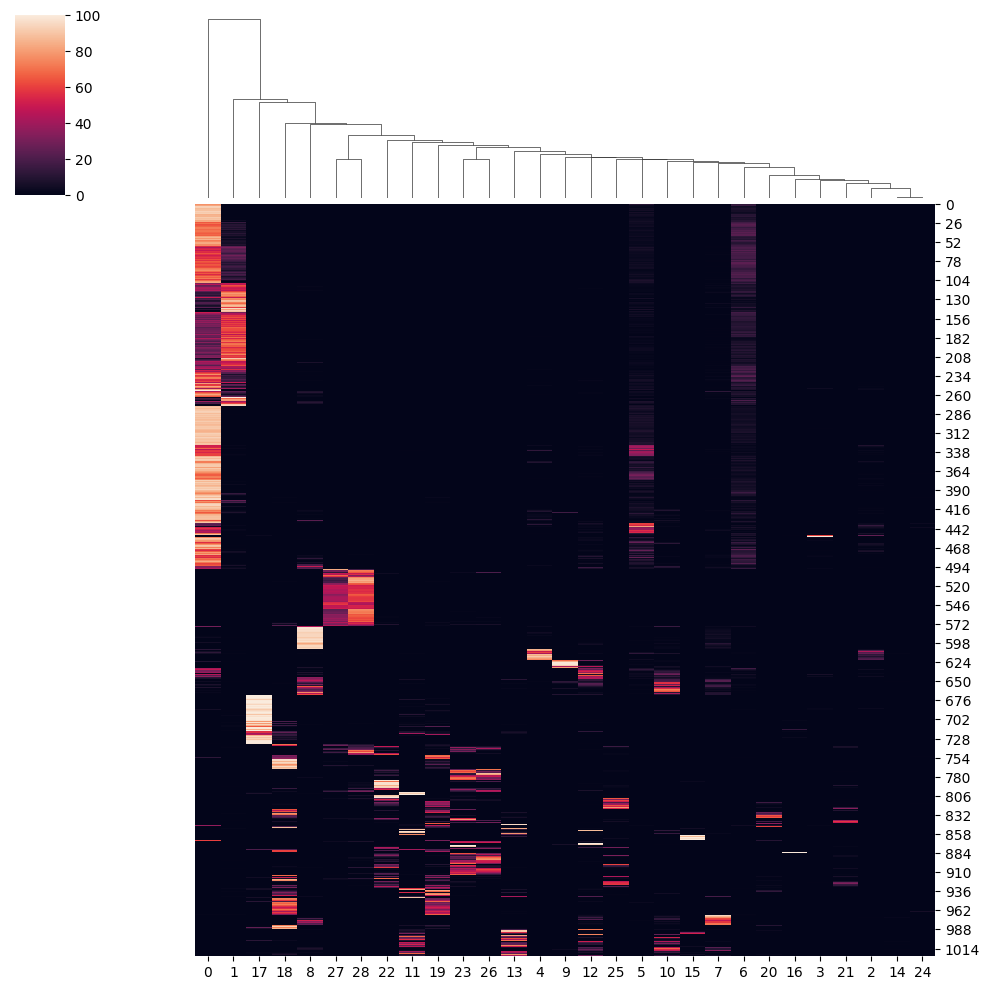

In [28]:
cg = sns.clustermap(class_stats,row_cluster=False,col_cluster=True)

In [44]:
reordered_cg = cg.dendrogram_col.reordered_ind

In [45]:
class_stats_reorder = class_stats[:,reordered_cg]

<Axes: >

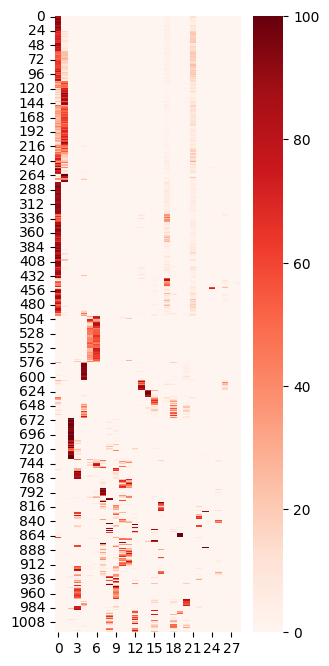

In [33]:
plt.figure(figsize=(3,8))
sns.heatmap(class_stats_reorder,cmap='Reds')
# plt.savefig('all_figs/Fig5/Gclass.png',dpi=300)

In [46]:
neighborhood_num = {'Pallium-Glut':0,'Subpallium-GABA':1,
                    'HY-EA-Glut-GABA':2,'TH-EPI-Glut':3,
                    'MB-HB-Glut-Sero-Dopa':4,'MB-HB-CB-GABA':5}

neighborhood_stats = np.zeros((len(D_exp2),6))
for i in range(len(reordered_index)):
     subclass_rows = np.array(Gsubclass_label[reordered_index[i]])
     tmp_subclasses = np.unique(subclass_rows)
     total_N = len(subclass_rows)
     tmp_neigh = {}
     for j in tmp_subclasses:
          tmp_n = subclass_to_neighborhood[int(j)]
          if ";" in tmp_n:
               tmp_n = tmp_n.split(";")[0]
          n = len(subclass_rows[subclass_rows == j])
          if tmp_n not in neighborhood_num:
               total_N = total_N - n
               continue
          if tmp_n not in tmp_neigh:
               tmp_neigh[neighborhood_num[tmp_n]] = n
          else:
               tmp_neigh[neighborhood_num[tmp_n]] += n
               
     for k,v in tmp_neigh.items(): 
          neighborhood_stats[i,k] = v/total_N*100

In [47]:
neighborhood_stats = np.array(neighborhood_stats)

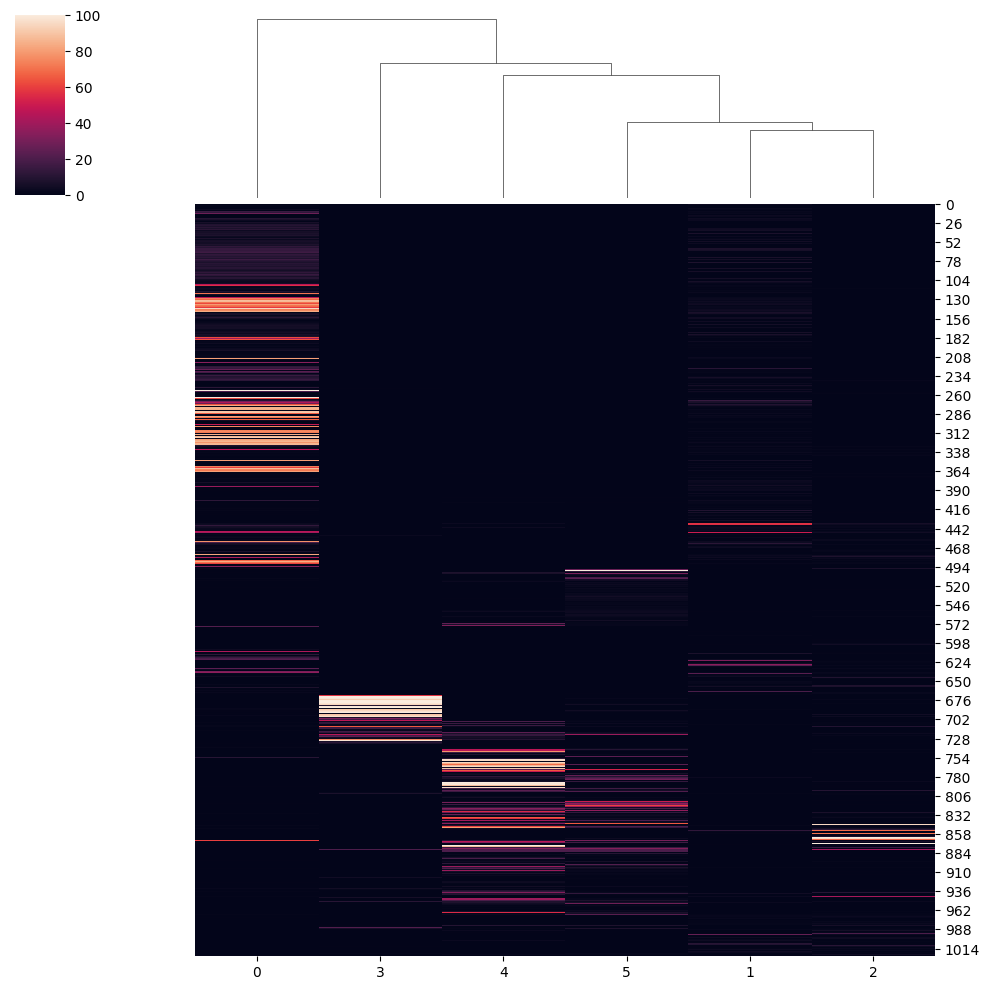

In [48]:
ng = sns.clustermap(neighborhood_stats,row_cluster=False,col_cluster=True)

In [49]:
ng_reorder = ng.dendrogram_col.reordered_ind
neighborhood_stats_reorder = neighborhood_stats[:,ng_reorder]

<Axes: >

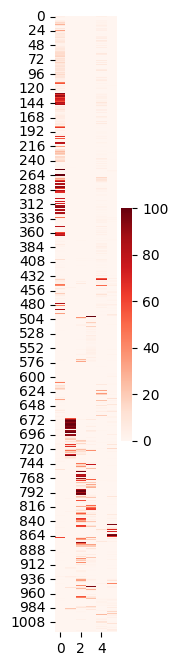

In [50]:
plt.figure(figsize=(1,8))
sns.heatmap(neighborhood_stats_reorder,cmap='Reds')
# plt.savefig('all_figs/Fig5/Gneighborhood.png',dpi=300)

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [16]:
from esda.moran import Moran
import pysal.lib as pslib
# import warnings
from scipy.spatial import distance_matrix
def moran_calc2(num_cluster,labels, coords):
    # warnings.filterwarnings('ignore',category=UserWarning)
    N = len(coords)
    if N > 60000:    
        ids = [10*i for i in range(int(np.floor(N/10)))]
        coords = coords[ids,:]
        labels = np.array(labels)[ids]
    dist_m = distance_matrix(coords,coords)
    thres = np.percentile(dist_m,25)
    weights = pslib.weights.DistanceBand.from_array(coords, threshold=thres)
    moran = Moran(labels, weights)
    avgI = moran.I
    pI = moran.p_norm
    zI = moran.z_norm
    return avgI,pI,zI

In [12]:
T_info1 = pd.read_csv('gene/screened_info1.csv')

In [17]:
%%capture

moran_func = True
if moran_func:
    moran_r, moran_scores,moran_r_parc, moran_scores_parc, moran_parc_ids = [],[],[],[],[]
else:
    std_r, std_scores,std_r_parc, std_scores_parc, std_parc_ids, std_delta_parc, cv_parc= [],[],[],[],[],[],[]

for i in REGION671:
    mask_path = 'lyf/output_full_r671/parc_region'+str(i)+'.nrrd'
    if not os.path.exists(mask_path):
        continue
    parc_mask_tmp = load_image(mask_path)
    N_parc = np.max(parc_mask_tmp)
    if N_parc <2:
        continue
    region_id = i
    acronym_name = brain_to_id[region_id]
    if acronym_name not in id_parc_match:
        acronym_name = acronym_name+"-unassigned"
    if acronym_name not in id_parc_match:
        continue
    r_name = id_parc_match[acronym_name]
    
    if moran_func:
        t_tmp_df = T_info1[T_info1['parcellation_index']==r_name]
        if len(t_tmp_df) < 10:
            continue
        s_names = np.array(t_tmp_df['cell_label'])
        c_tmp_df = c1_table[c1_table['cell_label'].isin(s_names)]
        R_df_tmp = pd.merge(c_tmp_df,t_tmp_df,on='cell_label')
        coords = R_df_tmp[['x_y','y_y','z_y']].values
        R_df_tmp['x_y'] = round(R_df_tmp['x_y']*40).astype(int)
        R_df_tmp['y_y'] = round(R_df_tmp['y_y']*40).astype(int)
        R_df_tmp['z_y'] = round(R_df_tmp['z_y']*40)
        R_df_tmp['z_y'] = R_df_tmp['z_y'].apply(lambda x: 456-x if x<228 else x)
        R_df_tmp['z_y'] = R_df_tmp['z_y'].astype(int)    
        g_labels = R_df_tmp['cluster'].apply(lambda x: int(x.split(' ')[0]))
        num_cluster = len(np.unique(g_labels))
        
        parc_labels = parc_mask_tmp[R_df_tmp['z_y'],R_df_tmp['y_y'],R_df_tmp['x_y']]
    
        moran_score,moran_pi,moran_zi = moran_calc2(num_cluster,g_labels, coords)
        moran_scores.append(moran_score)
        moran_r.append(brain_to_id[region_id])  
        
        del t_tmp_df,c_tmp_df, parc_mask_tmp
    else:
        t_tmp_df = T1[T1['parcellation_index']==r_name]
        if len(t_tmp_df) < 10:
            continue

        R_df_tmp = t_tmp_df

        R_df_tmp['x'] = round(R_df_tmp['x']*40).astype(int)
        R_df_tmp['y'] = round(R_df_tmp['y']*40).astype(int)
        R_df_tmp['z'] = round(R_df_tmp['z']*40)
        R_df_tmp['z'] = R_df_tmp['z'].apply(lambda x: 456-x if x<228 else x)
        R_df_tmp['z'] = R_df_tmp['z'].astype(int)

        parc_labels = parc_mask_tmp[R_df_tmp['z'],R_df_tmp['y'],R_df_tmp['x']]
     
        ss = StandardScaler()
        R_df_scaled = ss.fit_transform(R_df_tmp[col_s])
        pca = PCA(n_components=3)
        R_df_trans = pca.fit_transform(R_df_scaled)
        std_r.append(brain_to_id[region_id])
        top_std = np.std(R_df_trans,axis=0)
        std_scores.append(np.mean(top_std))
        
        # col_sum = np.sum(R_df_tmp[col_s])
        # col_sum_sorted = np.sort(col_sum)
        # nc = len(col_sum_sorted)
        # count_add = 0
        # col_ids = []
        # for c in range(3):
        #     v = col_sum_sorted[nc-c-1]
        #     idlist = np.where(col_sum == v)[0]
        #     for d in idlist:
        #         col_ids.append(col_s[d])
        #         count_add += 1
        #         if count_add  > 3:
        #             break
        #     if count_add > 3: 
        #         break
        
        # cv_overall = np.std(R_df_tmp[col_ids],axis=0)/np.mean(R_df_tmp[col_ids],axis=0)
    
        del t_tmp_df,parc_mask_tmp
    
    for j in range(1,N_parc+1):
        if moran_func:
            g2 = g_labels[parc_labels == j]
            if len(g2) <10:
                continue
            num_cluster_tmp = len(np.unique(g2))
            coords_tmp = coords[parc_labels == j,:]
            moran_score2,moran_pi2,moran_zi2 = moran_calc2(num_cluster_tmp,g2, coords_tmp)
            moran_scores_parc.append(moran_score2)
            moran_parc_ids.append(j)
            moran_r_parc.append(brain_to_id[region_id])
            
            del coords_tmp
        else: 
            tmp_rows = R_df_trans[parc_labels == j]
            if len(tmp_rows) <10:
                continue
            std_r_parc.append(brain_to_id[region_id])
            std_parc_ids.append(j)
        
            top_std_tmp = np.std(tmp_rows,axis=0)
            std_scores_parc.append(np.mean(top_std_tmp))
            std_delta_parc.append(np.mean(top_std_tmp)-np.mean(top_std))
            
            tmp_rows2 = R_df_tmp[parc_labels == j][col_ids]
            # cv_org = np.std(tmp_rows2,axis=0)/np.mean(tmp_rows2,axis=0)
            # cv_parc.append(np.mean(cv_org-cv_overall))
            del tmp_rows,tmp_rows2
    del R_df_tmp

In [18]:
def load_features(mefile, scale=25., feat_type='mRMR', flipLR=True):
    df = pd.read_csv(mefile, index_col=0, comment='#')
    
    if feat_type == 'full':
        cols = df.columns
        fnames = [fname for fname in cols if fname[-3:] == '_me']
    elif feat_type == 'mRMR':
        # Features selected by mRMR
        fnames = mRMR_f3me
    elif feat_type == 'PCA':
        fnames = ['pca_feat1', 'pca_feat2', 'pca_feat3']
    else:
        raise ValueError("Unsupported feature types")

    # standardize
    tmp = df[fnames]
    tmp = (tmp - tmp.mean()) / (tmp.std() + 1e-10)
    df[fnames] = tmp

    # scaling the coordinates to CCFv3-25um space
    df['soma_x'] /= scale
    df['soma_y'] /= scale
    df['soma_z'] /= scale
    # we should remove the out-of-region coordinates
    zdim,ydim,xdim = (456,320,528)   # dimensions for CCFv3-25um atlas
    in_region = (df['soma_x'] >= 0) & (df['soma_x'] < xdim) & \
                (df['soma_y'] >= 0) & (df['soma_y'] < ydim) & \
                (df['soma_z'] >= 0) & (df['soma_z'] < zdim)
    df = df[in_region]
    print(f'Filtered out {in_region.shape[0] - df.shape[0]}')

    if flipLR:
        # mirror right hemispheric points to left hemisphere
        zdim2 = zdim // 2
        nzi = (df['soma_z'] < zdim2).values.nonzero()
        loci = df.index[nzi]
        df.loc[loci, 'soma_z'] = zdim - df.loc[loci, 'soma_z']

    return df, fnames

In [19]:
me_file_path = 'BrainParcellation/microenviron/data/mefeatures_100K_with_PCAfeatures3.csv'
me_df_new, fnames_new = load_features(me_file_path, scale=25., feat_type='full', flipLR=True)

Filtered out 0


In [20]:
import pymrmr

In [21]:
### L2/3
def moran_calc_me(df, fnames):
    coords = df[['soma_x', 'soma_y', 'soma_z']]/40
    dist_m = distance_matrix(coords,coords)
    thres = np.percentile(dist_m,25)
    weights = pslib.weights.DistanceBand.from_array(coords.values, threshold=thres,binary=True)
    avgI = []
    pI = []
    zI = []
    for fn in fnames:
        moran = Moran(df[fn], weights)
        avgI.append(moran.I)
        pI.append(moran.p_norm)
        zI.append(moran.z_norm)
    return avgI,pI,zI

In [24]:
%%capture
moran_func2 = True
if moran_func2:
    moran_regions,moran_parcID,moran_I_all,moran_me_I,moran_me_r= [],[],[],[],[]
else:
    fstd_regions,fstd_parcID,fstd_I_all,fstd_me_I,fstd_me_r,fstd_delta_all,cv_parc_me= [],[],[],[],[],[],[]

for i in REGION671:
    mask_file = 'lyf/output_full_r671/parc_region'+str(i)+'.nrrd'
    if os.path.exists(mask_file):
        mask = load_image(mask_file)
        N_parc = np.max(mask)
        
        me_df_r = me_df_new[me_df_new['region_id_r671']==i]
        print(len(me_df_r))
        if len(me_df_r) < 10:
            continue
        if N_parc <2:
            continue
        
        me_df_r2 = me_df_r.copy()
        me_df_r2['soma_z'] = round(me_df_r2['soma_z']).astype(int)
        me_df_r2['soma_x'] = round(me_df_r2['soma_x']).astype(int)
        me_df_r2['soma_y'] = round(me_df_r2['soma_y']).astype(int)
    
        parc_labels = mask[me_df_r2['soma_z'],me_df_r2['soma_y'],me_df_r2['soma_x']]
        
        del mask
        
        if moran_func2:
            me_df_r2 = me_df_r2[fnames_new]
            me_df_r2.insert(loc=0,column='parc_id',value=parc_labels)
        
            mrmr_F = pymrmr.mRMR(me_df_r2,'MIQ',3)
        
            avgI_me,pI_me,zI_me = moran_calc_me(me_df_r, mrmr_F)
            moran_me_I.append(np.mean(avgI_me))
            moran_me_r.append(brain_to_id[i]) 
                
        else:
            tmp_scaled = StandardScaler().fit_transform(me_df_r[fnames_new])
        
            pca = PCA(n_components=3)
            tmp_trans = pca.fit_transform(tmp_scaled)
            top_std = np.std(tmp_trans,axis=0)
            meanSTD = np.mean(top_std)
            fstd_me_I.append(meanSTD)
            fstd_me_r.append(brain_to_id[i]) 
            
            me_df_r2 = me_df_r2[fnames_new]
            me_df_r2.insert(loc=0,column='parc_id',value=parc_labels)
        
            mrmr_F = pymrmr.mRMR(me_df_r2,'MIQ',3)
            
            cv_overall = np.std(me_df_r[mrmr_F],axis=0)/np.mean(me_df_r[mrmr_F],axis=0)
            del tmp_scaled

        for j in range(1,N_parc+1):
            if len(me_df_r[parc_labels == j]) < 10:
                continue
            
            if moran_func2:
                me_tmp = me_df_r[parc_labels == j]            
                avgI,pI,zI = moran_calc_me(me_tmp, mrmr_F)
                
                moran_I_all.append(np.mean(avgI))
                moran_regions.append(brain_to_id[i])
                moran_parcID.append(j)
                
                del me_tmp
            else:
                me_tmp = tmp_trans[parc_labels==j,:]
                top_std_tmp = np.std(me_tmp,axis=0)
                fstd_I_all.append(np.mean(top_std_tmp))
                fstd_regions.append(brain_to_id[i])
                fstd_parcID.append(j)
                fstd_delta_all.append(np.mean(top_std_tmp) - meanSTD)
                
                me_tmp2 = me_df_r[parc_labels == j][mrmr_F]
                cv_org = np.std(me_tmp2,axis=0)/np.mean(me_tmp2,axis=0)
                cv_parc_me.append(np.mean(cv_org-cv_overall))
                del me_tmp
        del me_df_r, me_df_r2



 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 5 	 OverallWidth_me 	 0.497
2 	 19 	 pc11_me 	 0.431
3 	 20 	 pc12_me 	 0.416

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 5 	 OverallWidth_me 	 0.497
2 	 21 	 pc13_me 	 3.506
3 	 1 	 Stems_me 	 3.103


 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-re

In [25]:
### match rows
moran_I_all2 = []
moran_R_full2 = []
moran_me_I2 = []
moran_me_R2 = []
keep_r_ids = []
n = 0
keep_parc_ids = []
for i in moran_r:
    if i in moran_me_r:
        moran_me_I2.append(moran_me_I[moran_me_r.index(i)])
        moran_me_R2.append(region_Rough[i])
        ids_tmp = np.where(np.array(moran_regions)==i)[0]
        ids_tmp2 = np.where(np.array(moran_r_parc)==i)[0]
        p_tmp = np.array(moran_parcID)[ids_tmp]
        p_tmp2 = np.array(moran_parc_ids)[ids_tmp2]
        ids_set = set(p_tmp).intersection(set(p_tmp2))
        tmp_p = []
        for k in list(ids_set):
            tmp_p.append(ids_tmp[np.where(p_tmp == k)[0][0]])
        for j in tmp_p:
            moran_I_all2.append(moran_I_all[j])
            moran_R_full2.append(region_Rough[i])
            keep_parc_ids.append(ids_tmp2[np.where(p_tmp2 == moran_parcID[j])[0][0]])
        keep_r_ids.append(n)
    n += 1

In [ ]:
### match rows
fstd_I_all2 = []
fstd_R_full2 = []
fstd_me_I2 = []
fstd_me_R2 = []
keep_r_ids2 = []
fstd_delta_all2 = []
cv_parc_me2 = []
n = 0
keep_parc_ids2 = []
for i in std_r:
    if i in fstd_me_r:
        fstd_me_I2.append(fstd_me_I[fstd_me_r.index(i)])
        fstd_me_R2.append(region_Rough[i])
        ids_tmp = np.where(np.array(fstd_regions)==i)[0]
        ids_tmp2 = np.where(np.array(std_r_parc)==i)[0]
        p_tmp = np.array(fstd_parcID)[ids_tmp]
        p_tmp2 = np.array(std_parc_ids)[ids_tmp2]
        ids_set = set(p_tmp).intersection(set(p_tmp2))
        tmp_p = []
        for k in list(ids_set):
            tmp_p.append(ids_tmp[np.where(p_tmp == k)[0][0]])
        for j in tmp_p:
            fstd_I_all2.append(fstd_I_all[j])
            fstd_R_full2.append(region_Rough[i])
            fstd_delta_all2.append(fstd_delta_all[j])
            cv_parc_me2.append(cv_parc_me[j])
            keep_parc_ids2.append(ids_tmp2[np.where(p_tmp2 == fstd_parcID[j])[0][0]])
        keep_r_ids2.append(n)
    n += 1

In [26]:
moran_r2 = np.array(moran_r)[keep_r_ids]
moran_scores2 = np.array(moran_scores)[keep_r_ids]
moran_r_parc2 = np.array(moran_r_parc)[keep_parc_ids]
moran_scores_parc2 = np.array(moran_scores_parc)[keep_parc_ids]

In [27]:
moran_R = []
for i in moran_r2:
    moran_R.append(region_Rough[i])
moran_R = np.array(moran_R)
moran_R2 = []
for i in moran_r_parc2:
    moran_R2.append(region_Rough[i])
moran_R2 = np.array(moran_R2)

In [28]:
moran_R_full2 = np.array(moran_R_full2)
moran_me_R2 = np.array(moran_me_R2)

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [31]:
cmap = mpl.cm.rainbow
color_hm = cmap(np.linspace(0,1,len(major_BS_name)-1))
color_hm2 = [mpl.colors.rgb2hex(i,keep_alpha=False) for i in color_hm]

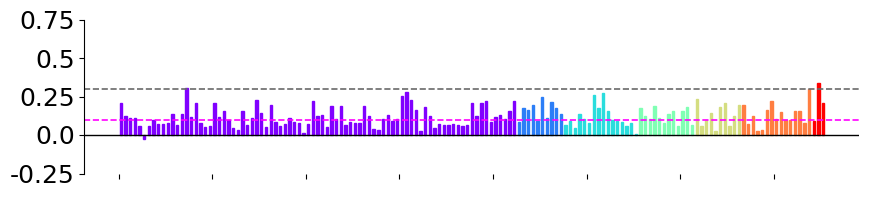

In [32]:
plt.figure(figsize=(10,2))
current = 0.5
for i in range(len(major_BS_name)-1):
    score_tmp = np.array(moran_me_I2)[moran_me_R2==major_BS_name[i]]
    score_tmp = score_tmp*100
    bin_positions = np.arange(current,len(score_tmp)+current)
    plt.bar(bin_positions,score_tmp,width =0.5,color = color_hm2[i],align='center',edgecolor=color_hm2[i])
    current += len(score_tmp)
# plt.xlabel('Moran I',fontsize=15)
# plt.ylabel('#Sub-parcellation',fontsize=15)
plt.axhline(10,color='magenta',linestyle='--',linewidth=1.2)
plt.axhline(30,color='dimgray',linestyle='--',linewidth=1.2)
plt.axhline(0,color='black',linewidth=1)
plt.tick_params(labelbottom=False,labelleft=True)
plt.yticks([25*i for i in range(-1,4)],[str(0.25*i) for i in range(-1,4)],fontsize = 18)
ax = plt.gca()
for spine in ['right','top','bottom']:
    ax.spines[spine].set_visible(False)
# plt.savefig('all_figs/Fig5/moran_me_regions.png',dpi=300)

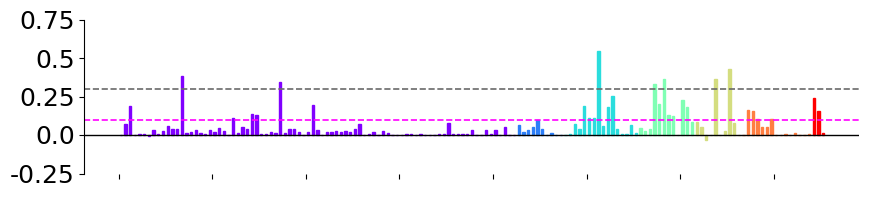

In [33]:

plt.figure(figsize=(10,2))
current = 0.5
for i in range(len(major_BS_name)-1):
    score_tmp = np.array(moran_scores2)[moran_R==major_BS_name[i]]
    score_tmp = score_tmp*100
    # score_tmp = list(score_tmp)
    bin_positions = np.arange(current,len(score_tmp)+current)
    plt.bar(bin_positions,score_tmp,width =0.5,color = color_hm2[i],align='center',edgecolor=color_hm2[i])
    current += len(score_tmp)
# plt.xlabel('Moran I',fontsize=15)
# plt.ylabel('#Sub-parcellation',fontsize=15)
plt.axhline(10,color='magenta',linestyle='--',linewidth=1.2)
plt.axhline(30,color='dimgray',linestyle='--',linewidth=1.2)
plt.axhline(0,color='black',linewidth=1)
plt.tick_params(labelbottom=False,labelleft=True)
plt.yticks([25*i for i in range(-1,4)],[str(0.25*i) for i in range(-1,4)],fontsize = 18)
ax = plt.gca()
for spine in ['right','top','bottom']:
    ax.spines[spine].set_visible(False)
# plt.savefig('all_figs/Fig5/moran_regions.png',dpi=300)